# Ph.D. Course - Data Vizualization 
#### Authors
-  Manuele Pasini - manuele.pasini@unibo.it
- Gianni Tumedei - gianni.tumedei2@unibo.it

In [1]:
import pandas as pd
import os
import numpy as np

input_path = os.path.join(os.sep, "home", "dataset")
output_path = os.path.join(os.sep, "home", "results")

#### Preprocessing

In [2]:
devices = pd.read_csv(os.path.join(input_path, 'devices.csv'))
measurements = pd.read_csv(os.path.join(input_path, 'measurements.csv'))

measurements["deveui"] = measurements["deveui"].str.replace("-", "").str.upper()
measurements = measurements.drop(columns=["acceleration_x", "acceleration_y", "acceleration_z"])
measurements = measurements.rename(columns={"deveui": "device_id"})

devices = devices.rename(columns={"id": "device_id"})
devices = devices.drop(columns=["type", "status", "installed", "addedBy"])

# Merge the two dataframes on the 'device_id' column
merged_df = pd.merge(devices, measurements, on='device_id')

# Convert the 'location' column to a (lon,lat) format
merged_df["location"] = merged_df.apply(lambda row: f"{row['location/0']}, {row['location/1']}", axis=1)
merged_df = merged_df.drop(columns=["location/0", "location/1"])

# Convert the 'timestamp' column to datetime format
merged_df["time"] = pd.to_datetime(merged_df["time"], unit='ms')
merged_df["time"] = merged_df["time"].dt.strftime('%Y-%m-%d %H:%M:%S')

# Remove columns with more than 60% missing values
missing_threshold = 0.6
cleaned_df = merged_df.loc[:, merged_df.isnull().mean() < missing_threshold]

merged_df.to_csv(os.path.join(output_path, 'merged_data.csv'), index=False)

### Dataset overview

In [3]:
print(f"Number of devices: {merged_df["device_id"].unique().size}")
print(f"Number of distinct devices {merged_df["desc"].unique().size}")

print(f"Number of measurements: {merged_df.size}")
print(f"Measurements time window: from {merged_df["time"].min()} to {merged_df["time"].max()}")

merged_df

Number of devices: 429
Number of distinct devices 358
Number of measurements: 92285265
Measurements time window: from 2020-08-01 00:00:02 to 2021-02-23 20:32:28


,device_id,floor,desc,time,temperature,humidity,light,motion,co2,battery,sound_avg,sound_peak,moisture,pressure,location
0,A81758FFFE046433,4,Attached to old video projector mount,2020-08-01 00:01:10,23.6,39.0,2.0,20.0,NaN,3.641,34.0,64.0,NaN,NaN,"65.05765, 25.46897"
1,A81758FFFE046433,4,Attached to old video projector mount,2020-08-01 00:05:11,23.7,39.0,2.0,21.0,NaN,3.638,34.0,64.0,NaN,NaN,"65.05765, 25.46897"
2,A81758FFFE046433,4,Attached to old video projector mount,2020-08-01 00:09:10,23.6,39.0,2.0,21.0,NaN,3.638,34.0,64.0,NaN,NaN,"65.05765, 25.46897"
3,A81758FFFE046433,4,Attached to old video projector mount,2020-08-01 00:13:11,23.7,39.0,2.0,22.0,NaN,3.641,34.0,64.0,NaN,NaN,"65.05765, 25.46897"
4,A81758FFFE046433,4,Attached to old video projector mount,2020-08-01 00:17:11,23.6,39.0,2.0,18.0,NaN,3.641,34.0,64.0,NaN,NaN,"65.05765, 25.46897"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6152346,A81758FFFE030FFE,1,Hallway next to LO105,2021-02-23 19:29:38,21.8,7.0,41.0,2.0,635.0,3.689,NaN,NaN,NaN,NaN,"65.05809, 25.46576"
6152347,A81758FFFE030FFE,1,Hallway next to LO105,2021-02-23 19:44:38,21.9,7.0,3.0,0.0,640.0,3.686,NaN,NaN,NaN,NaN,"65.05809, 25.46576"
6152348,A81758FFFE030FFE,1,Hallway next to LO105,2021-02-23 19:59:38,21.8,7.0,3.0,0.0,636.0,3.689,NaN,NaN,NaN,NaN,"65.05809, 25.46576"
6152349,A81758FFFE030FFE,1,Hallway next to LO105,2021-02-23 20:14:38,21.8,7.0,3.0,0.0,637.0,3.686,NaN,NaN,NaN,NaN,"65.05809, 25.46576"


#### Filter, format, and group data for the first visualization

In [4]:
filtered_df = merged_df.copy()
filtered_df["time"] = pd.to_datetime(filtered_df["time"], errors="coerce").dt.tz_localize("UTC", ambiguous="NaT")

# Define the date ranges to exclude
start_date = pd.Timestamp("2020-09-01T00:00:00Z")
end_date = pd.Timestamp("2021-05-10T23:59:59Z")
filtered_df = filtered_df[(filtered_df["time"] >= start_date) & (filtered_df["time"] <= end_date)]
exclusion_ranges = [
    (pd.Timestamp("2020-10-12T00:00:00Z"), pd.Timestamp("2020-10-18T23:59:59Z")), # Autumn break (Syysloma) week 42
    (pd.Timestamp("2020-12-21T00:00:00Z"), pd.Timestamp("2021-01-06T23:59:59Z")), # Christmas break
    (pd.Timestamp("2020-03-08T00:00:00Z"), pd.Timestamp("2020-03-14T23:59:59Z"))  # Winter break week 10
]
# Apply filters
for start, end in exclusion_ranges:
    filtered_df = filtered_df[~((filtered_df["time"] >= start) & (filtered_df["time"] <= end))]

# Remove weekends
filtered_df = filtered_df[filtered_df["time"].dt.weekday < 5]
# Only keep floor 1
filtered_df = filtered_df[filtered_df["floor"] == 1]
# Only keep rows with motion and sound values
filtered_df = filtered_df.dropna(subset=["motion", "sound_avg"])
# Remove outliers
# outliers = ["A81758FFFE046462", "A81758FFFE04652A", "A81758FFFE046572"]
# filtered_df = filtered_df[~filtered_df["device_id"].isin(outliers)]

# Add linearized sound because plotting logarithmic values is useless
filtered_df["sound_avg_linear"] = 10 ** (filtered_df["sound_avg"] / 20)
filtered_df["sound_peak_linear"] = 10 ** (filtered_df["sound_peak"] / 20)

filtered_df.to_csv(os.path.join(output_path, "filtered_data.csv"), index=False)

filtered_df

,device_id,floor,desc,time,temperature,humidity,light,motion,co2,battery,sound_avg,sound_peak,moisture,pressure,location,sound_avg_linear,sound_peak_linear
91086,A81758FFFE046500,1,Next to yellow guide signs,2020-09-01 00:13:55+00:00,20.7,40.0,70.0,83.0,NaN,3.638,34.0,64.0,NaN,NaN,"65.06081, 25.46679",50.118723,1584.893192
91087,A81758FFFE046500,1,Next to yellow guide signs,2020-09-01 00:28:55+00:00,20.7,40.0,69.0,87.0,NaN,3.638,34.0,64.0,NaN,NaN,"65.06081, 25.46679",50.118723,1584.893192
91088,A81758FFFE046500,1,Next to yellow guide signs,2020-09-01 00:43:55+00:00,20.6,39.0,69.0,84.0,NaN,3.638,34.0,64.0,NaN,NaN,"65.06081, 25.46679",50.118723,1584.893192
91089,A81758FFFE046500,1,Next to yellow guide signs,2020-09-01 00:58:55+00:00,20.7,39.0,70.0,83.0,NaN,3.638,34.0,64.0,NaN,NaN,"65.06081, 25.46679",50.118723,1584.893192
91090,A81758FFFE046500,1,Next to yellow guide signs,2020-09-01 01:13:55+00:00,20.7,39.0,70.0,84.0,NaN,3.638,34.0,64.0,NaN,NaN,"65.06081, 25.46679",50.118723,1584.893192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6037478,A81758FFFE0463B5,1,Hallway next to LO105,2021-02-23 19:22:41+00:00,21.9,7.0,17.0,85.0,NaN,3.639,37.0,68.0,NaN,NaN,"65.05807, 25.46584",70.794578,2511.886432
6037479,A81758FFFE0463B5,1,Hallway next to LO105,2021-02-23 19:37:41+00:00,21.8,7.0,17.0,80.0,NaN,3.639,35.0,64.0,NaN,NaN,"65.05807, 25.46584",56.234133,1584.893192
6037480,A81758FFFE0463B5,1,Hallway next to LO105,2021-02-23 19:52:40+00:00,21.9,7.0,1.0,80.0,NaN,3.637,35.0,64.0,NaN,NaN,"65.05807, 25.46584",56.234133,1584.893192
6037481,A81758FFFE0463B5,1,Hallway next to LO105,2021-02-23 20:07:40+00:00,21.8,7.0,1.0,84.0,NaN,3.639,35.0,64.0,NaN,NaN,"65.05807, 25.46584",56.234133,1584.893192


In [6]:
filtered_df["hour"] = filtered_df["time"].dt.hour

# Group by "device_id" and "hour"
grouped_df = filtered_df.groupby(["device_id", "hour"]).agg(
    floor=("floor", "first"),
    desc=("desc", "first"),
    temperature=("temperature", "mean"),
    humidity=("humidity", "mean"),
    light=("light", "mean"),
    motion=("motion", "mean"),
    co2=("co2", "mean"),
    battery=("battery", "mean"),
    sound_avg=("sound_avg", "mean"),
    sound_peak=("sound_peak", "mean"),
    sound_avg_linear=("sound_avg_linear", "mean"),
    sound_peak_linear=("sound_peak_linear", "mean"),
    moisture=("moisture", "mean"),
    pressure=("pressure", "mean"),
    location=("location", "first")
).reset_index()

grouped_df.to_csv(os.path.join(output_path, 'grouped_data.csv'), index=False)

grouped_df

,device_id,hour,floor,desc,temperature,humidity,light,motion,co2,battery,sound_avg,sound_peak,sound_avg_linear,sound_peak_linear,moisture,pressure,location
0,A81758FFFE046337,0,1,In the middle of Kastari,21.276147,27.865443,0.000000,83.623853,NaN,3.635217,49.660550,64.000000,308.469821,1584.893192,NaN,NaN,"65.05702, 25.46767"
1,A81758FFFE046337,1,1,In the middle of Kastari,21.269706,27.385294,0.000000,83.855882,NaN,3.635129,49.591176,64.002941,307.293440,1585.461975,NaN,NaN,"65.05702, 25.46767"
2,A81758FFFE046337,2,1,In the middle of Kastari,21.056587,27.404192,0.362275,83.523952,NaN,3.635237,49.988024,66.287425,328.101785,3208.544770,NaN,NaN,"65.05702, 25.46767"
3,A81758FFFE046337,3,1,In the middle of Kastari,20.535000,27.447059,1.629412,83.170588,NaN,3.635059,50.800000,70.438235,361.421157,5521.481641,NaN,NaN,"65.05702, 25.46767"
4,A81758FFFE046337,4,1,In the middle of Kastari,20.091691,26.922636,2.644699,83.808023,NaN,3.634731,51.297994,72.074499,386.405504,6097.472105,NaN,NaN,"65.05702, 25.46767"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,A81758FFFE046583,19,1,L7,20.184150,27.775216,26.841499,78.968300,NaN,3.627666,34.253602,64.510086,53.240307,2027.585352,NaN,NaN,"65.0599, 25.46602"
2228,A81758FFFE046583,20,1,L7,20.156627,27.927711,25.262048,79.006024,NaN,3.627735,34.114458,64.096386,50.861932,1614.259575,NaN,NaN,"65.0599, 25.46602"
2229,A81758FFFE046583,21,1,L7,20.121662,27.875371,26.243323,79.103858,NaN,3.627837,34.103858,64.080119,50.794251,1611.848977,NaN,NaN,"65.0599, 25.46602"
2230,A81758FFFE046583,22,1,L7,20.076900,27.784195,25.680851,79.313070,NaN,3.627681,34.173252,64.036474,51.328041,1599.253923,NaN,NaN,"65.0599, 25.46602"


### More overview

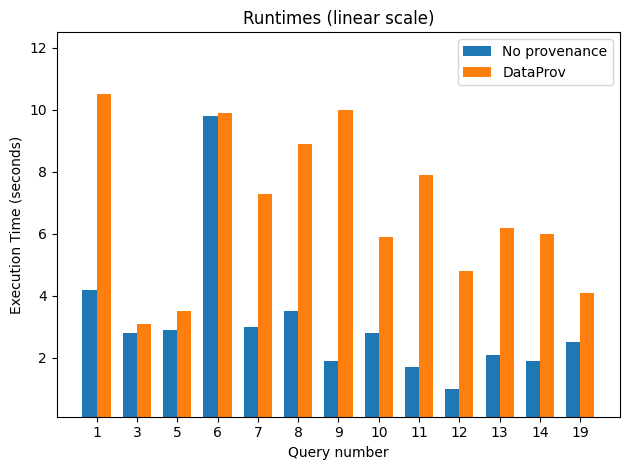

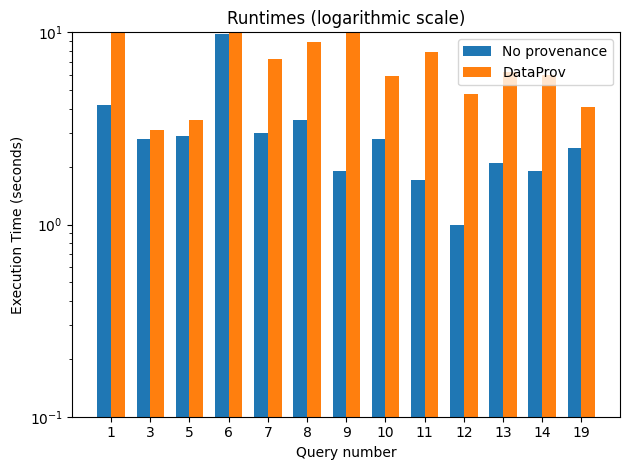

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = [
    {'id': 1,  'valore': 4.2, 'prov': False},
    {'id': 1,  'valore': 10.5, 'prov': True},
    {'id': 3,  'valore': 2.8, 'prov': False},
    {'id': 3,  'valore': 3.1, 'prov': True},
    {'id': 5,  'valore': 2.9, 'prov': False},
    {'id': 5,  'valore': 3.5, 'prov': True},
    {'id': 6,  'valore': 9.8, 'prov': False},
    {'id': 6,  'valore': 9.9, 'prov': True},
    {'id': 7,  'valore': 3.0, 'prov': False},
    {'id': 7,  'valore': 7.3, 'prov': True},
    {'id': 8,  'valore': 3.5, 'prov': False},
    {'id': 8,  'valore': 8.9, 'prov': True},
    {'id': 9,  'valore': 1.9, 'prov': False},
    {'id': 9,  'valore': 10.0, 'prov': True},
    {'id': 10, 'valore': 2.8, 'prov': False},
    {'id': 10, 'valore': 5.9, 'prov': True},
    {'id': 11, 'valore': 1.7, 'prov': False},
    {'id': 11, 'valore': 7.9, 'prov': True},
    {'id': 12, 'valore': 1.0, 'prov': False},
    {'id': 12, 'valore': 4.8, 'prov': True},
    {'id': 13, 'valore': 2.1, 'prov': False},
    {'id': 13, 'valore': 6.2, 'prov': True},
    {'id': 14, 'valore': 1.9, 'prov': False},
    {'id': 14, 'valore': 6.0, 'prov': True},
    {'id': 19, 'valore': 2.5, 'prov': False},
    {'id': 19, 'valore': 4.1, 'prov': True}
]

df = pd.DataFrame(data)

ids = sorted(df['id'].unique())

val_false = df[df['prov'] == False].set_index('id')['valore'].reindex(ids)
val_true  = df[df['prov'] == True ].set_index('id')['valore'].reindex(ids)

x = np.arange(len(ids))
width = 0.35

ymax = 12
fig, ax = plt.subplots()


val_false_clipped = np.minimum(val_false, ymax)
val_true_clipped = np.minimum(val_true, ymax)

bars1 = ax.bar(x - width/2, val_false_clipped, width, label='No provenance')
bars2 = ax.bar(x + width/2, val_true_clipped,  width, label='DataProv')

ax.set_xticks(x)
ax.set_xticklabels(ids)
ax.set_xlabel('Query number')
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Runtimes (linear scale)')
ax.set_ylim(bottom=0.1, top=ymax + 0.5)
ax.legend()


for i, (real, clipped) in enumerate(zip(val_false, val_false_clipped)):
    if real > ymax:
        ax.text(x[i] - width/2, ymax, f'{real:.1f}', ha='center', va='bottom', fontsize=8, color='red')

for i, (real, clipped) in enumerate(zip(val_true, val_true_clipped)):
    if real > ymax:
        ax.text(x[i] + width/2, ymax, f'{real:.1f}', ha='center', va='bottom', fontsize=8, color='red')

plt.tight_layout()
plt.show()


fig, ax = plt.subplots()
ax.bar(x - width/2, val_false, width, label='No provenance')
ax.bar(x + width/2, val_true,  width, label='DataProv')
ax.set_xticks(x)
ax.set_xticklabels(ids)
ax.set_xlabel('Query number')
ax.set_ylabel('Execution Time (seconds)')
ax.set_yscale('log')
ax.set_ylim(bottom=0.1, top= 10)
ax.set_title('Runtimes (logarithmic scale)')
ax.legend()
plt.tight_layout()
plt.show()

### Visualization 1 - Manuele Pasini

### Visualization 1 - Gianni Tumedei